# Comparison and features of Deuces package implementation
Comparing the speed of poker hand evaluation and probability computation using Monte Carlo simulation techniques. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import itertools

sns.set_theme()

### Speed of previous implementation

In [2]:
import pokerUtils
from pokerUtils import score_hand, Deck, runSimulation, computeProbability

In [3]:
%%timeit
simOut = runSimulation(1000,hand=['H13','C13'])
# print('probability of winning with pocket kings (n=1,000): {}%'.format(
#     round(np.sum(simOut)/len(simOut)*100,4)))

1.31 s ± 56.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To compute a probability using only the hole cards takes the old implementation 1.32 s per evaluation. 

In [4]:
%%timeit
simOut = runSimulation(1000,hand=['H13','C13'],flop=['D13'])
# print('probability of winning with pocket kings (n=1,000): {}%'.format(
#     round(np.sum(simOut)/len(simOut)*100,4)))

1.29 s ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The speed of the evaluation should not be effected by the input of other cards that would be theoretically dealt in other rounds, this is because these cards would be simulated internally if they were not entered. Thus, the combinations of the hold cards with the board is still the same level of rigor regardless of the inputs for the dealt rounds. 

### Speed using Deuces Implementation

In [5]:
import deucesCode
from deucesCode import runSims, Evaluator, Deck

evalObj = Evaluator()

In [7]:
%%timeit
simOut = runSims(evalObj,1000,hole=['H13','C13'],board=[])

156 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
simOut = runSims(evalObj,1000,hole=['H13','C13'],board=['D13'])

160 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Testing of individual scoring functions

Old method
> Note, in the old method for a 7 card (board + hole cards) evaluation, all the combinations of the 7 cards had to be computed and then each of those combinations scored.

In [9]:
def combinations(arr, n):
    arr = np.asarray(arr)
    t = np.dtype([('', arr.dtype)]*n)
    result = np.fromiter(itertools.combinations(arr, n), t)
    return result.view(arr.dtype).reshape(-1, n)

In [10]:
board = ['H13','C13','D13','H2','C10']
hand = ['H10','D7']

In [11]:
%%timeit
combos = combinations(hand+board,5)

scores = [score_hand(c,scoreOnly=True) for c in combos]

228 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Note, Deuces testing here is being used with 7 cards total but it can score it in a single call, the old method requires you to compile the combinations between the cards into 5 card hands from the original 7. Thus, this computation should be included in the timing of the approach because it is required in practice.

Deuces Testing

In [12]:
%%timeit
[deucesCode.deucesFormatConvert(c) for c in hand]

2.76 µs ± 80.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Above is the timing of the format conversion.

In [13]:
from deucesCode import Deck
deck = Deck()
aEval = Evaluator()

hand = deck.draw(2)
board = deck.draw(5)

In [14]:
%%timeit
aEval.evaluate(hand,board)

20.9 µs ± 538 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Above is the timing of the same 7 card evaluation from Deuces instead of the old methodology. 

### Conclusions
The Deuces implementation provides significantly faster scoring of poker hands than the previous implementation. When comparing the evaluation of 7 cards using the same methodology Deuces is roughly 200 times faster. 

In terms of the Monte Carlo probability models, the difference is milliseconds to seconds (deuces, old method respectively) so thousands of times faster. 

This will allow for the evaluation and creation of the probability factors of the newly created poker game dataset. This dataset has approximately 42,000 games, roughly assuming that each game has only one player and one game to quantify, Deuces will allow the calculations to occur in roughly 3-4 hours with its millisecond computation time where previously it would have taken over a day. 

### Deuces Robustness Testing 

In [17]:
pdf = pd.DataFrame({i : runSims(evalObj,1000,hole=['H13','C13'],board=['D13']) for i in tqdm(range(200))},index=['probWin']).transpose()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.07it/s]


<AxesSubplot:ylabel='Frequency'>

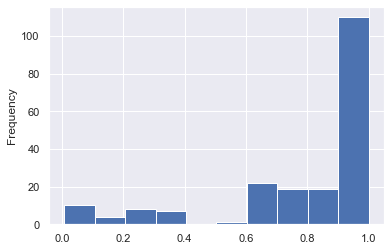

In [28]:
pdf['probWin'].plot(kind='hist')

In [29]:
pdf['probWin'].std()

0.27780825420697564

In [31]:
pdf['probWin'].mean()

0.7953950000000006

In [23]:
pdf1 = pd.DataFrame({i : runSims(evalObj,1000,hole=['H13','C13'],board=['D13','C10','S10']) for i in tqdm(range(200))},index=['probWin']).transpose()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.18it/s]


In [26]:
pdf1['probWin'].std()

0.07241296977030269

In [27]:
pdf1['probWin'].mean()

0.9633000000000003

<AxesSubplot:ylabel='Frequency'>

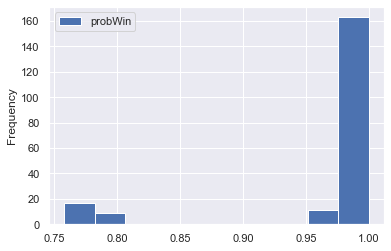

In [25]:
pdf1.plot(kind='hist')

There are some slightly odd patterns that emerge when examing the large sample sizes. 

In [32]:
pdf1 = pd.DataFrame({i : runSims(evalObj,1000,hole=['H13','C13'],board=['D13','C10','S2','D10']) for i in tqdm(range(200))},index=['probWin']).transpose()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.11it/s]


In [33]:
pdf1['probWin'].std()

0.042791028682171085

In [34]:
pdf1 = pd.DataFrame({i : runSims(evalObj,1000,hole=['H13','C13'],board=['D13','C10','S2','D10','C6']) for i in tqdm(range(200))},index=['probWin']).transpose()

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.00it/s]


In [35]:
pdf1['probWin'].std()

0.0022871665119239435

There does appear to be trend between decreased standard deviation (uncertainty) and the number of input cards into the board, this conceptually makes sense. 